In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import tensorflow as tf
from tensorflow import keras
tf.config.list_physical_devices('GPU')
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing import text,sequence
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,SimpleRNN,LSTM,SpatialDropout1D,GRU,Bidirectional,Input,Dense,Activation,Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
# from keras.layers.core import Dense#,Activation,Dropout


In [3]:
import tensorflow as tf
print("Num of GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num of GPUs:  0
2.13.0


'3.8.2rc1 (tags/v3.8.2rc1:8623e68, Feb 11 2020, 10:46:21) [MSC v.1916 64 bit (AMD64)]'

In [4]:
from tqdm import tqdm

In [5]:
#configuring TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU', tpu.master())
except ValueError:
    tpu = None

In [6]:
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    #default distribution strategy in tensorflow, Works on CPU and single GPU
    strategy = tf.distribute.OneDeviceStrategy("CPU:0")

In [7]:
train = pd.read_csv('C:/Users/Richa/OneDrive/Documents/Desktop/TARP PROJECT_TOXIC COMMENT/dataset/jigsaw-toxic-comment-train.csv')
validation = pd.read_csv('C:/Users/Richa/OneDrive/Documents/Desktop/TARP PROJECT_TOXIC COMMENT/dataset/validation.csv')
test = pd.read_csv('C:/Users/Richa/OneDrive/Documents/Desktop/TARP PROJECT_TOXIC COMMENT/dataset/test.csv')

In [8]:
train.shape

(223549, 8)

In [9]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis = 1, inplace = True)

In [11]:
#check max len of comment_text column to use this for padding in future
pad_len = train['comment_text'].apply(lambda x:len(str(x).split())).max()
print('max len of comment_text column',pad_len)

max len of comment_text column 2321


DATA PREPARATION

In [12]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, stratify = train.toxic.values, random_state = 42,test_size = 0.3,shuffle = True)

In [13]:
len(xtrain),len(xvalid)

(156484, 67065)

### Tokenisation and Padding with max len of words in curpus

In [14]:
test.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [15]:
#using keras tokenizer
token = text.Tokenizer(num_words = None)
max_len = 2400
xtest = test.content.values
token.fit_on_texts(list(xtrain) + list(xvalid) + list(xtest))

x_train_seq = token.texts_to_sequences(xtrain)
x_valid_seq = token.texts_to_sequences(xvalid)
x_test_seq = token.texts_to_sequences(xtest)

#zero pad the sequences
x_train_pad = pad_sequences(x_train_seq,maxlen = max_len)


x_valid_pad = pad_sequences(x_valid_seq,maxlen = max_len)
x_test_pad = pad_sequences(x_test_seq,maxlen = max_len)
word_index = token.word_index

### Classification on basic RNN Network

In [16]:
len(word_index) + 1

583777

In [17]:
%%time
with strategy.scope():

    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1,activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2400, 300)         175133100 
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 175173301 (668.23 MB)
Trainable params: 175173301 (668.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
CPU times: total: 6.45 s
Wall time: 1.37 s


In [18]:
#using strategy to run the TPU
model.fit(x_train_pad,ytrain,epochs = 3,batch_size = 128*strategy.num_replicas_in_sync)

Epoch 1/3
1223/1223 [==============================] - 12184s 10s/step - loss: 0.1951 - accuracy: 0.9349
Epoch 2/3
1223/1223 [==============================] - 13918s 11s/step - loss: 0.1471 - accuracy: 0.9494
Epoch 3/3
1223/1223 [==============================] - 24438s 20s/step - loss: 0.1309 - accuracy: 0.9535


In [19]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import numpy as np

In [20]:
pred_val = model.predict(x_valid_pad)

2096/2096 [==============================] - 2559s 1s/step


In [21]:
model_accuracy = roc_auc_score(yvalid,pred_val)

In [22]:
model_accuracy_ls = []
model_accuracy_ls.append({'model':'simpleRNN','AUC_SCORE':model_accuracy})

In [23]:
model_accuracy_ls

[{'model': 'simpleRNN', 'AUC_SCORE': 0.9061570194033333}]

In [24]:
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(yvalid, pred_val)
roc_auc = auc(fpr, tpr)

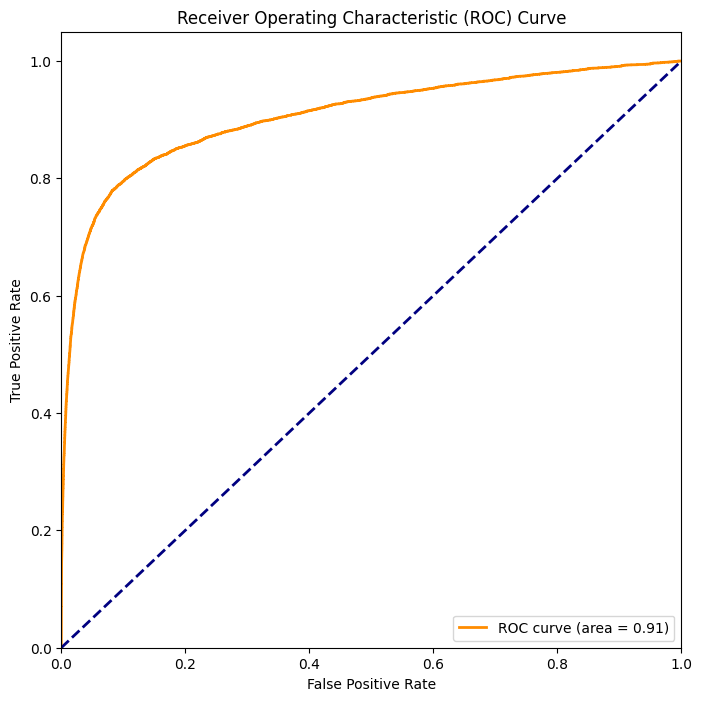

In [25]:
# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

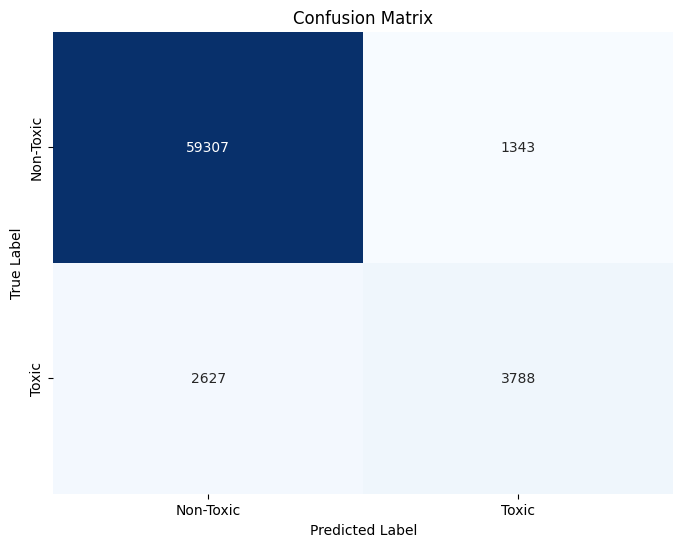

In [26]:
# Threshold predictions to convert probabilities to binary predictions
threshold = 0.5  # You can adjust this threshold as needed
binary_pred_val = (pred_val > threshold).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(yvalid, binary_pred_val)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()